# Egocentric coding

We want to explore the hypothesis that some neurons encode for the direction of the home base relative to the heading direction.

We will start with a more generic hypothesis that a neuron might encode an egocentric bearing angle to any point near the environment explored by the animal.

Note that as the reference point moves away from the environment explored by the animal, egocentric bearing becomes indistinguisable from allocentric head direction coding. For this reason, we will restrict our analysis to reference points near the environment explored by the animal.

<div>
<img src="../images/egocentric_bearing_angle.png" width="300"/>
</div>


The aims for this notebook are:

1. simulate an egocentric bearing neuron.
2. estimate the reference point using the position data and spike train.


## Assumptions

1. The firing rate of the neuron as a function of egocentric bearing has the shape of a cos function.
2. The search for the reference point will maximize the spike train and maximize the vector length of the tuning curve.



In [97]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize,basinhopping
from scipy.stats import poisson, norm, vonmises
from scipy.special import factorial
import animal_trajectory

plt.rcParams["figure.figsize"] = (25, 5)

Path of the animal

Rec time:700 sec
dt:0.02 sec
samples:35000


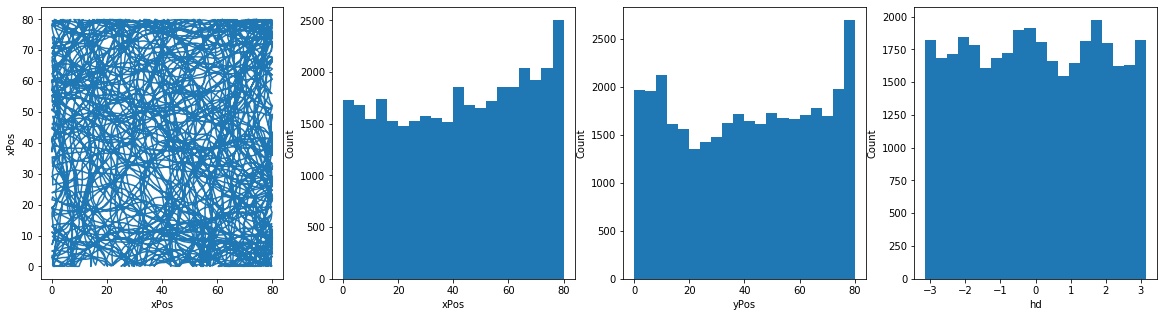

In [98]:
boxSize=80
samplingRate = 50
recordingTimeSec=700
samples=recordingTimeSec*samplingRate
dt = 1/samplingRate
stepSizeRatio = 25/samplingRate # to give it a speed of 25 cm per sec

print("Rec time:{} sec".format(recordingTimeSec))
print("dt:{} sec".format(dt))
print("samples:{}".format(samples))

position_x,position_y,head_direction = animal_trajectory.walk(samples,boxSize,stepSizeRatio)
animal_trajectory.plotPath(position_x,position_y,head_direction)
time = np.linspace(0,recordingTimeSec,samples)


## Calculate the egocentric bearing angle

Set a reference point.

Calculate the ego bearing angle

In [99]:
def egocentric_direction_to_reference_point(x_animal, y_animal, hd, x_res,y_ref):
    """
    Function to calculate the egocentric direction of a reference point relative the the head direction of the animal.
    
    Angle between 2 vectors:
    1) A vector from the animal head pointing in it head direction 
    2) A vector from the animals head pointing towards a reference point
    
    This tells you in which direction the reference point was relative to the antero-posterior axis of the animal head.
    
    np.arctan2 is used to get the angle of the vector from animal position to ref point
    We use a second np.arctan2 to make sure the results are within -pi to pi
    The values are reversed so that -pi/2 is to the left and pi/2 is to right
    
    
    Arguments:
    x_animal: 1D np.array of with x position of the animal
    y_animal: 1D np.array of the y position of the animal
    hd: 1D np.array of the head direction of the animal
    x_ref: reference point x coordinate
    y_ref: reference point y coordinate
    
    Returns:
    Egocentric angle in radian of the reference point relative to a vector pointing in front of the animal's head. 
        0: in front of the animal, -pi: to the left, pi: to the right, 2*pi : to the back
    """
    
    
    return - np.arctan2(np.sin(np.arctan2(y_ref-y_animal,x_ref-x_animal)-hd),np.cos(np.arctan2(y_ref-y_animal,x_ref-x_animal)-hd))


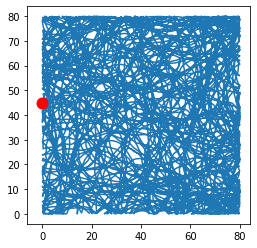

In [151]:
plt.figure(figsize=(4,4))
x_ref=0
y_ref=45
plt.plot(position_x,position_y,zorder=0)
plt.scatter(x_ref,y_ref,c="red",s=120,zorder=2)

In [152]:
ego = egocentric_direction_to_reference_point(position_x,position_y,head_direction,x_ref,y_ref)

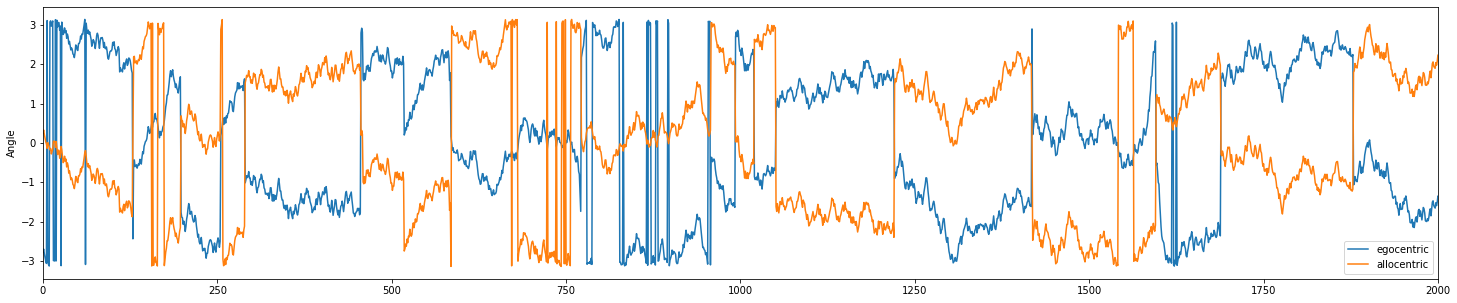

In [153]:
plt.plot(ego, label="egocentric")
plt.xlim(0,2000)
plt.plot(head_direction, label="allocentric")
plt.ylabel("Angle")
plt.legend()
plt.show()

## Egocentric bearing selectivity

The von Mises distribution is the equivalant of a Gaussian distribution for circular data.

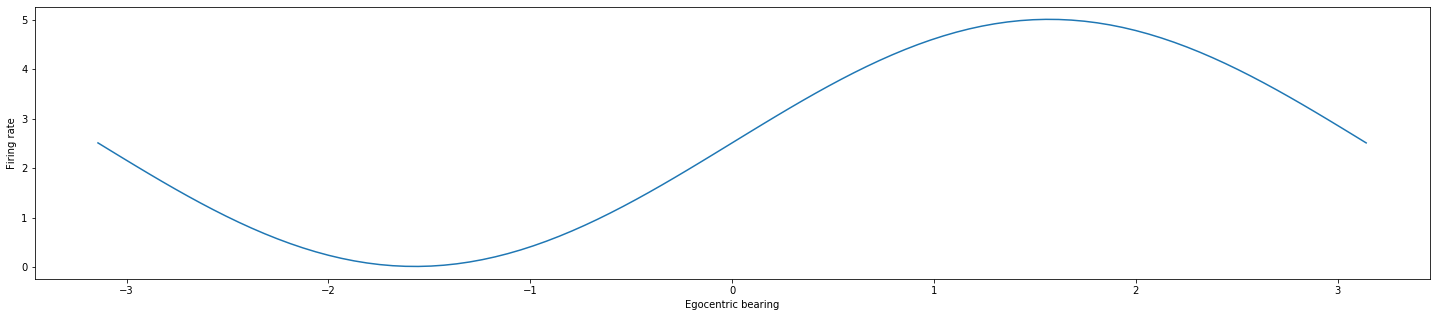

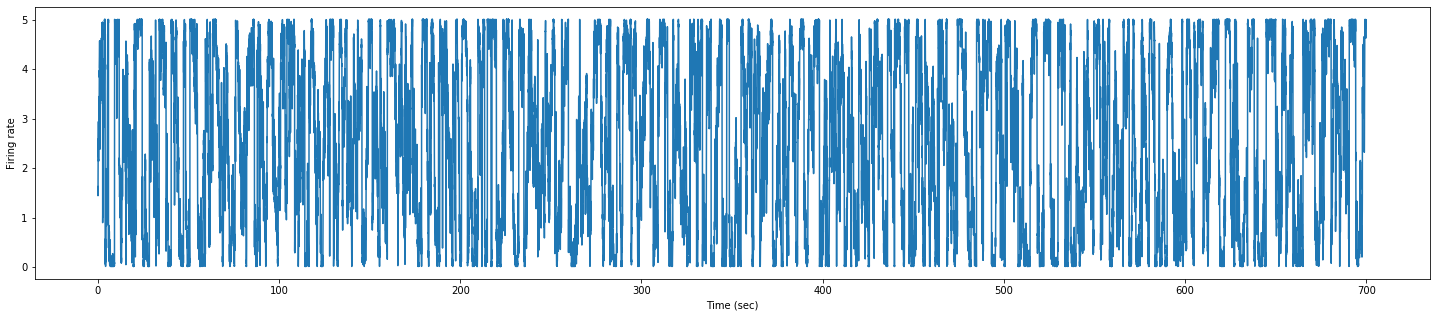

In [175]:
thetaP= np.pi/2
gain = 5

x = np.linspace(-np.pi, np.pi, 100)

y = gain*(np.cos(x-thetaP)+1)/2+0.01
plt.plot(x, y)
plt.xlabel("Egocentric bearing")
plt.ylabel("Firing rate")
plt.show()

E_rate = gain*(np.cos(ego-thetaP)+1)/2+0.01
plt.plot(time, E_rate)
plt.xlabel("Time (sec)")
plt.ylabel("Firing rate")
plt.show()

## Simulate a spike train with the estimated rate

x_ref: 0, y_ref: 45, thetaP: 1.57, gain: 5.00
dt: 0.02


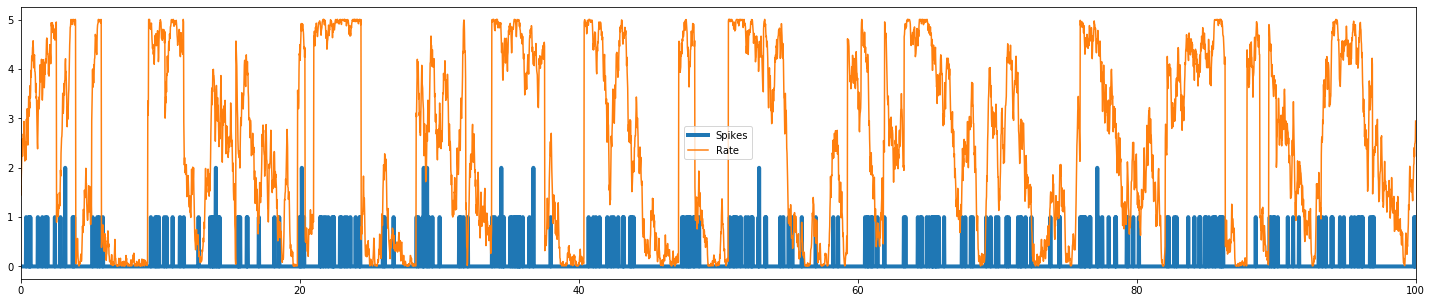

In [176]:
ox_ref=x_ref
oy_ref=y_ref
othetaP=thetaP
ogain=gain

print("x_ref: {}, y_ref: {}, thetaP: {:.02f}, gain: {:.02f}".format( x_ref,y_ref,thetaP,gain))
print("dt: {}".format(dt))
spikes = poisson.rvs(mu=E_rate*dt) # sample from a Poisson distribution. We pass the rate array to the function.
plt.plot(time,spikes,lw=4, label="Spikes")
plt.plot(time,E_rate, label="Rate")
plt.xlim(0,100)
plt.legend()
plt.show()

In [177]:
np.sin(0)

0.0

In [178]:
def egoTuningCurve(position_x,position_y,head_direction,x_ref,y_ref,plot=False):
    
    ego = egocentric_direction_to_reference_point(position_x,position_y,head_direction,x_ref,y_ref)
    
    degPerBin=np.pi*2/10
    nBins=2*np.pi/degPerBin
    bins = np.arange(-np.pi,np.pi+degPerBin,degPerBin)
    occ,edges = np.histogram(ego,bins= bins)
    occ=occ*dt

    spikeCounts=np.zeros_like(occ)
    binIndices = ((ego+np.pi)/degPerBin).astype(int)
    binIndices=binIndices

    for i,count in enumerate(spikes): # ugly for loop
        spikeCounts[binIndices[i]]+= count

    rate_histo = spikeCounts/occ
    
    
    angle = bins[0:-1]
    x = np.sum(np.cos(angle)*rate_histo)/np.sum(rate_histo)
    y = np.sum(np.sin(angle)*rate_histo)/np.sum(rate_histo)
    vl = np.sqrt(x**2+y**2)
    
    
    if(plot):
        fig,ax = plt.subplots(1,3,figsize=(15,4))

        ax[0].plot(occ)
        ax[0].set_ylim(0,occ.max())
        ax[0].set_ylabel("Time (sec)")

        ax[1].plot(spikeCounts)
        ax[1].set_ylim(0,spikeCounts.max())
        ax[1].set_ylabel("Spikes")

        ax[2].plot(rate_histo)
        ax[2].set_ylim(0,rate_histo.max())
        ax[2].set_ylabel("Rate (Hz)")
        ax[2].set_xlabel("Ego ({:.2f} rad per bin)".format(degPerBin))
        plt.show()
    
    return occ, spikeCounts, rate_histo, vl

In [179]:
egoTuningCurve(position_x,position_y,head_direction,ox_ref,oy_ref)

(array([71.18, 57.46, 69.98, 70.02, 73.94, 66.9 , 69.14, 70.56, 75.24,
        75.58]),
 array([132.,  30.,   0.,  49., 113., 231., 316., 321., 318., 264.]),
 array([1.8544535 , 0.52210233, 0.        , 0.69980006, 1.52826616,
        3.4529148 , 4.57043679, 4.54931973, 4.22647528, 3.49298756]),
 0.4731053738703993)

# Estimate the reference point given the spike train

We need to estimate what the reference point is given the spike train. This seems like an optimization problem.

We could evaluate the sqared difference of predicted and observed rate of the neuron.

Parameters to estimate:

* RefX
* RefY
* thetaP
* gain



      fun: 6656.064703519358
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.01509761,  0.03183231,  0.02883098, -0.0005457 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 120
      nit: 20
     njev: 24
   status: 0
  success: True
        x: array([ 0.16418822, 45.42950121,  1.59138987,  4.16675545])
mx_ref: 0.16, my_ref: 45.43, mthetaP: 1.59, mgain: 4.17
x_ref: 0, y_ref: 45, thetaP: 1.57, gain: 5.00


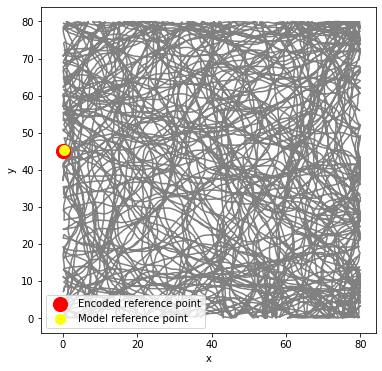

CPU times: user 850 ms, sys: 71.9 ms, total: 922 ms
Wall time: 769 ms


In [180]:
%%time
def objective_function(x0,spikes,list_Xt):
    """
    Function for which we want to find the minimum
    
   
    Returns 
    
    Negative log likelihood because our optimizer will look for the minimum
    """
    
    # set the parameters back to their array
    x_ref = x0[0]
    y_ref = x0[1]
    thetaP = x0[2]
    gain = x0[3]
    
        
    x_animal = list_Xt[0]
    y_animal = list_Xt[1]
    hd = list_Xt[2]
    dt = list_Xt[3]
    
    # egocentric bearing angle of the reference point
    ego = - np.arctan2(np.sin(np.arctan2(y_ref-y_animal,x_ref-x_animal)-hd),np.cos(np.arctan2(y_ref-y_animal,x_ref-x_animal)-hd))
    
    # estimate the rate in time 
    r = dt * gain * (np.cos(ego-thetaP)+1)/2 + 0.01
        
    # loglikelihood of these rates given the spike times    
    l = np.sum(spikes * np.log(r) - r - np.log(factorial(spikes))) # log likelihood, high is more likely
    
    # vl of spikes
    #_,_,_,vl = egoTuningCurve(position_x,position_y,head_direction,x_ref,y_ref,plot=False) # this is very slow
    #print(vl,-l, -l*(1-vl))
    
    
    #print("x_ref: {:.2f}, y_ref: {:.2f}, thetaP: {:.2f}, gain: {:.2f}, likelihood: {:.2f}".format(x_ref,y_ref, thetaP, gain,-l))
    #return -l + 1000*(1-vl) 
    return -l 


## set all parameters in a 1D array
list_Xt = [position_x,position_y,head_direction,dt]

# initialize learned parameters
x0= np.array([40,40,np.pi/2,5]) #(x_ref,y_res and 10 angular bins)

# bounds for the parameters
bnds = [(boxSize/2-100,boxSize/2+100),(boxSize/2-100,boxSize/2+100),(-np.pi,np.pi),(1,200.0)]

# minimize function, 
results = minimize(fun=objective_function,x0=x0,args=(spikes,list_Xt), bounds=bnds, options={"maxiter":20000,'disp':True})

# We sometimes get stuck in local minima, I am trying optimize.basinhopping() to solve this issue
minimizer_kwargs = {"bounds": bnds,
                  "args":(spikes,list_Xt)}

#results = basinhopping(func=objective_function, x0=x0, minimizer_kwargs=minimizer_kwargs,niter=200)


mx_ref = results.x[0]
my_ref = results.x[1]
mthetaP = results.x[2]
mgain = results.x[3]

print(results)

print("mx_ref: {:.2f}, my_ref: {:.2f}, mthetaP: {:.2f}, mgain: {:.2f}".format(mx_ref,my_ref, mthetaP, mgain))
print("x_ref: {}, y_ref: {}, thetaP: {:.02f}, gain: {:.02f}".format(x_ref,y_ref,thetaP,gain))
plt.figure(figsize=(6,6))
plt.plot(position_x,position_y,c="gray",zorder=0)
plt.scatter(ox_ref,oy_ref,c="red",zorder=1,s=200,label="Encoded reference point")
plt.scatter(mx_ref,my_ref,c="yellow",zorder=2,s=100, label="Model reference point")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

* Egocentric tuning curve using the spike train of the neuron, so that we can compare real and model-derived tuning curves.
* We need to test our minimizer with several different neurons, save the results, inspect the main issues. 

## Compare the tuning curves from the same spike train (model ref point vs simulation ref point)

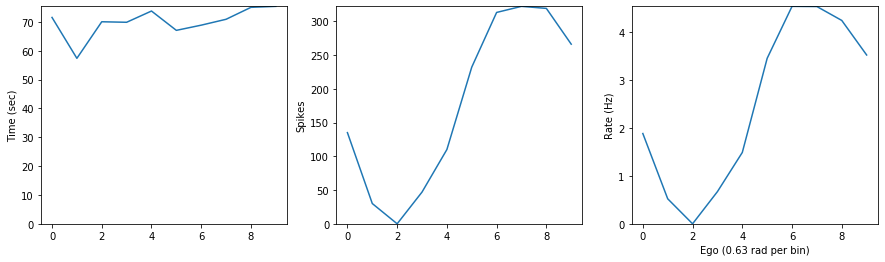

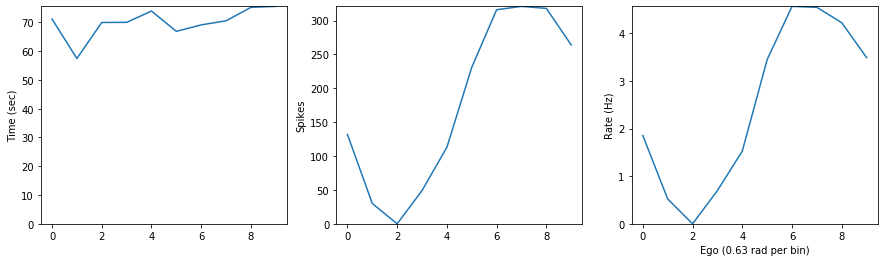

0.4741925733822512 0.4731053738703993


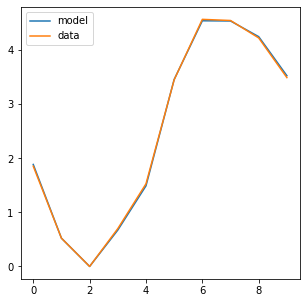

In [181]:
_,_,mh,vlm = egoTuningCurve(position_x,position_y,head_direction,mx_ref,my_ref,plot=True)
_,_,oh,vlo = egoTuningCurve(position_x,position_y,head_direction,ox_ref,oy_ref,plot=True)
print(vlm,vlo)
plt.figure(figsize=(5,5))
plt.plot(mh,label="model")
plt.plot(oh, label = "data")
plt.legend()
plt.show()

## Create a grid search for local minima

We sometimes get different results depending on the startin conditions.
Try to create a grid of 125 bins 5x5x5 (x,y,ego) of starting conditions. Store the results and get the lowest minimum.

## Quantify the accuracy of our model 

Write functions to easily simulate 100 neurons and retrieve the model parameters. 

1. Quantify the error in retrieval of ref point. 
2. Test the effect of noise in the firing rate of the neuron on the retrieval.
3. Test the effect of peak firing rate on the retrieval error.
4. Test the effect of number of spikes on the retrieval error.
5. Test the effect of recording time on the retrieval error.
6. Test the effect of a different tuning curve (vonMises, different kappa) on the retrival error
